In [ ]:
import torch
import itertools
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os

In [ ]:
train_data = os.listdir('./Colton AI project/Myositis Images/train_data/')
train_label = os.listdir('./Colton AI project/Myositis Images/train_label/')
train_mask_label = os.listdir('./Colton AI project/Myositis Images/train_mask_label/')

In [ ]:
selected_data = set(['_'.join(_.split('_')[:4]) for _ in train_data])

In [ ]:
np.unique([_[:13] for _ in selected_data], return_counts=True)

(array(['121919_Myo089', '121919_Myo208', '121919_Myo231', '121919_Myo253',
        '121919_Myo368', '121919_Myo388', '121919_Myo511'], dtype='<U13'),
 array([36, 27,  8, 33, 52, 23,  9]))

In [ ]:
# train data (121): 121919_Myo089, 121919_Myo253, 121919_Myo368
# validation data (50): 121919_Myo208, 121919_Myo388
# test data (17): 121919_Myo231, 121919_Myo511 

In [ ]:
train_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy') for idx in range(48)] 
              for _ in selected_data if _[:13] in ['121919_Myo089', '121919_Myo253', '121919_Myo368']]
validation_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy') for idx in range(48)] 
                   for _ in selected_data if _[:13] in ['121919_Myo208', '121919_Myo388']]
test_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy') for idx in range(48)] 
             for _ in selected_data if _[:13] in ['121919_Myo231', '121919_Myo511']]
train_list = list(itertools.chain(*train_list))
validation_list = list(itertools.chain(*validation_list))
test_list = list(itertools.chain(*test_list))
print('train data: {}'.format(len(train_list)))
print('validation data: {}'.format(len(validation_list)))
print('test data: {}'.format(len(test_list)))

train data: 5808
validation data: 2400
test data: 816


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        input = np.load('./Colton AI project/Myositis Images/train_data/' + self.file_list[idx][0])
        target = np.load('./Colton AI project/Myositis Images/train_label/' + self.file_list[idx][1])
        mask_label = np.load('./Colton AI project/Myositis Images/train_mask_label/' + self.file_list[idx][2])
        input = torch.from_numpy(input).unsqueeze(0)
        target = torch.from_numpy(target).unsqueeze(0)
        mask_label = torch.from_numpy(mask_label / 255).unsqueeze(0)

        if self.transform:
            input = self.transform(input)

        return (input, target, mask_label)

In [ ]:
dataloader = {}
dataloader['train'] = DataLoader(CustomDataset(train_list), batch_size=16, shuffle=True, num_workers=8, drop_last=False)
dataloader['validation'] = DataLoader(CustomDataset(validation_list), batch_size=32, shuffle=False, num_workers=8, drop_last=False)
dataloader['test'] = DataLoader(CustomDataset(test_list), batch_size=32, shuffle=False, num_workers=8, drop_last=False)

In [ ]:
datasize = {'train': len(train_list), 'validation': len(validation_list), 'test': len(test_list)}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

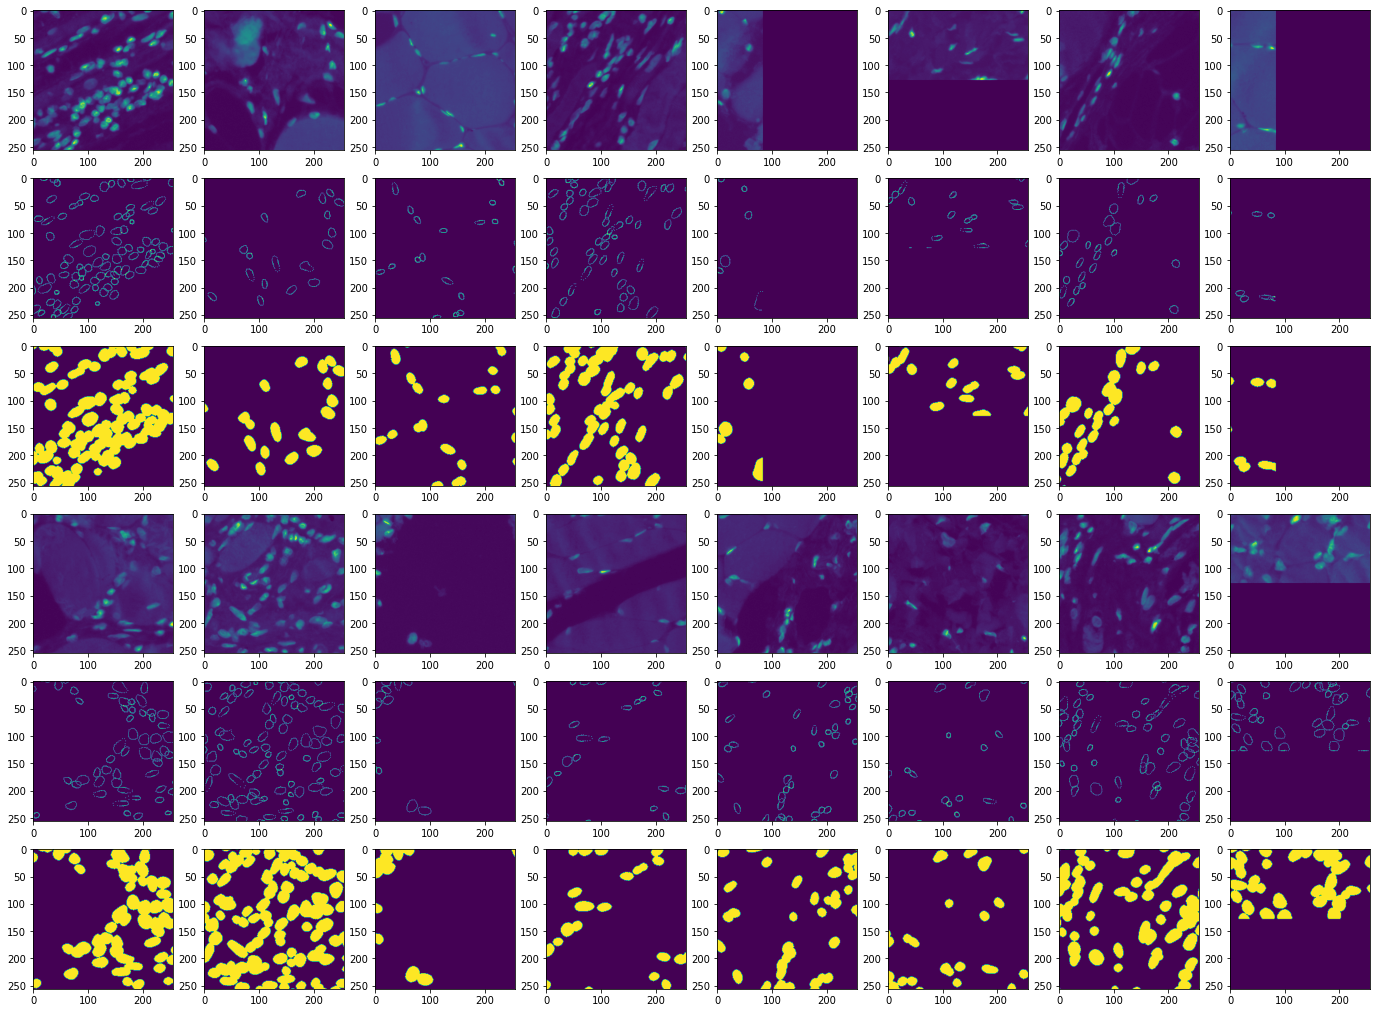

In [ ]:
inputs, target, mask_label = next(iter(dataloader['train']))
plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(mask_label[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(mask_label[_].squeeze().numpy())
plt.show()

# visualize dice+BCE loss model

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model_load = torch.load('./Colton AI project/Myositis Images/model/unet_fa_{:.3f}_ba_{:.3f}.pt'.format(0.880, 0.954), map_location=device)
model = model_load['model'].to(device)

Using cache found in /home/fz477/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
model.eval()   # Set model to evaluate mode

boundary_correct = 0
boundary_total = 0
background_correct = 0
background_total = 0
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['validation']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    boundary_correct += pred[target.bool()].sum().item()
    boundary_total += target.sum().item()
    background_correct += (pred[~mask_label.bool()] == 0.).sum().item()
    background_total += (~mask_label.bool()).sum().item()
    
epoch_bdry_acc = boundary_correct / boundary_total
epoch_bkgd_acc = background_correct / background_total
epoch_acc = (epoch_bdry_acc + epoch_bkgd_acc) / 2
print('Validation Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_bdry_acc, epoch_bkgd_acc, epoch_acc))

Validation Boundary Acc: 0.892864, Background Acc: 0.994751, Overall Acc: 0.943808


In [ ]:
model.eval()   # Set model to evaluate mode

numerator = 0.
denominator = 0.
epsilon = 1e-6
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['validation']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    numerator += 2 * torch.sum(pred * target).item() + epsilon
    denominator += (torch.sum(pred).item() + torch.sum(target).item() + epsilon)
    
dice = numerator / denominator
print('Validation Dice score: {:4f}'.format(dice))

Validation Dice score: 0.356546


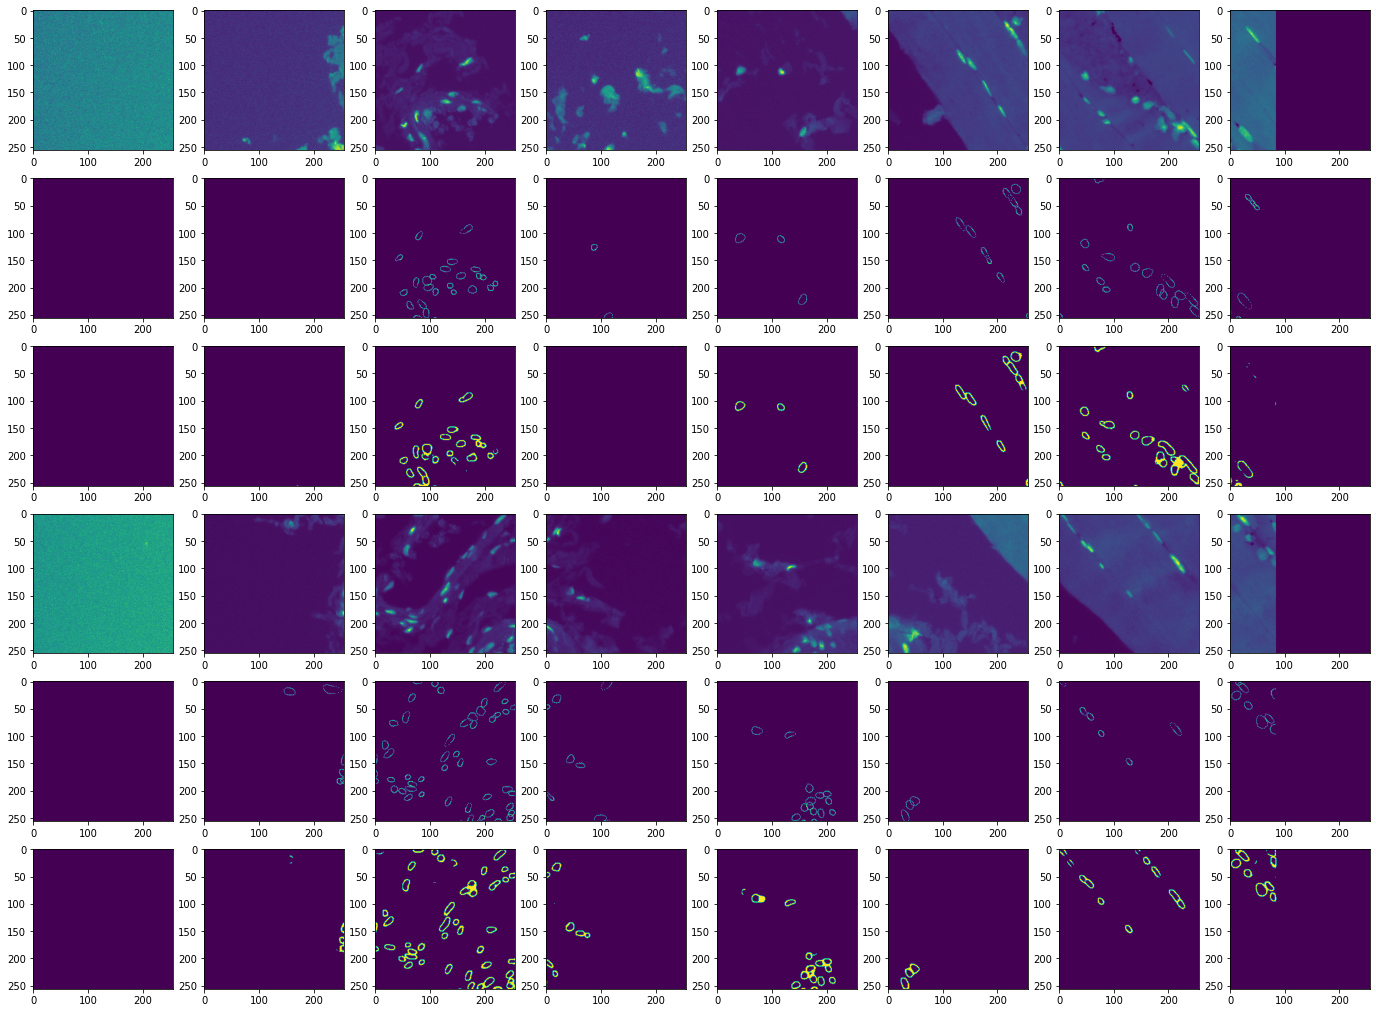

In [ ]:
thres = 0.5

inputs, target, mask_label = next(iter(dataloader['validation']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(output[_].squeeze().numpy())
plt.show()

In [ ]:
model = model_load['model'].to(device)
model.eval()   # Set model to evaluate mode

boundary_correct = 0
boundary_total = 0
background_correct = 0
background_total = 0
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['test']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    boundary_correct += pred[target.bool()].sum().item()
    boundary_total += target.sum().item()
    background_correct += (pred[~mask_label.bool()] == 0.).sum().item()
    background_total += (~mask_label.bool()).sum().item()
    
epoch_bdry_acc = boundary_correct / boundary_total
epoch_bkgd_acc = background_correct / background_total
epoch_acc = (epoch_bdry_acc + epoch_bkgd_acc) / 2
print('Validation Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_bdry_acc, epoch_bkgd_acc, epoch_acc))

Validation Boundary Acc: 0.870409, Background Acc: 0.996354, Overall Acc: 0.933382


In [ ]:
model.eval()   # Set model to evaluate mode

numerator = 0.
denominator = 0.
epsilon = 1e-6
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['test']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    numerator += 2 * torch.sum(pred * target).item() + epsilon
    denominator += (torch.sum(pred).item() + torch.sum(target).item() + epsilon)
    
dice = numerator / denominator
print('Validation Dice score: {:4f}'.format(dice))

Validation Dice score: 0.361010


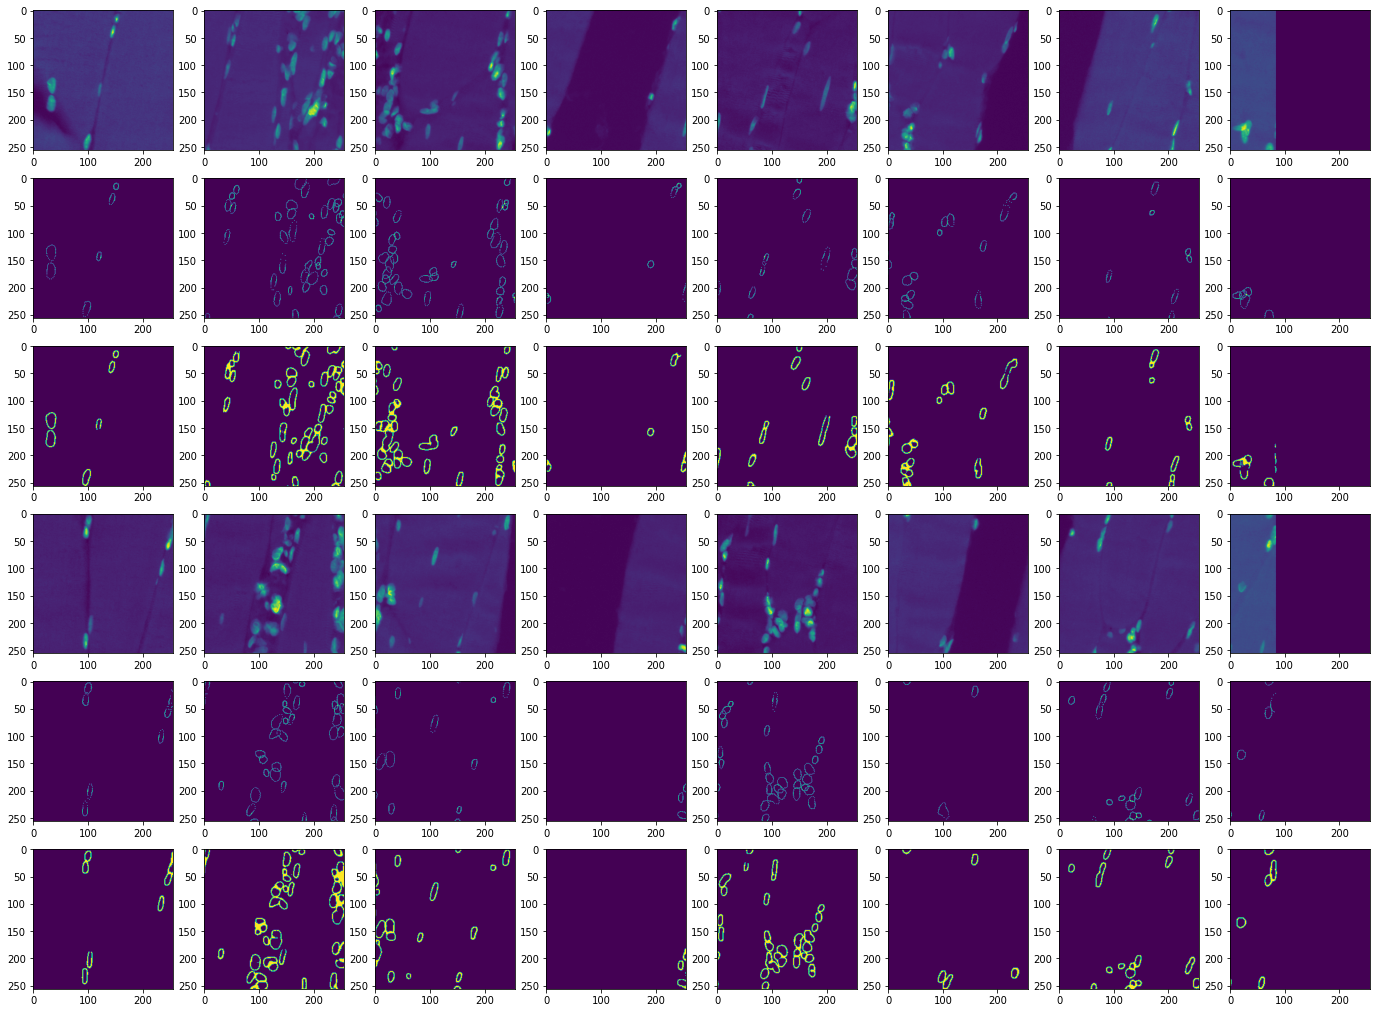

In [ ]:
thres = 0.5

inputs, target, mask_label = next(iter(dataloader['test']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(output[_].squeeze().numpy())
plt.show()

# visualize dice+BCE loss tile model

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model_load = torch.load('./Colton AI project/Myositis Images/model_tile/unet_fa_{:.3f}_ba_{:.3f}.pt'.format(0.960, 0.911), map_location=device)
model = model_load['model'].to(device)

Using cache found in /home/fz477/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
model.eval()   # Set model to evaluate mode

boundary_correct = 0
boundary_total = 0
background_correct = 0
background_total = 0
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['validation']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    boundary_correct += pred[target.bool()].sum().item()
    boundary_total += target.sum().item()
    background_correct += (pred[~mask_label.bool()] == 0.).sum().item()
    background_total += (~mask_label.bool()).sum().item()
    
epoch_bdry_acc = boundary_correct / boundary_total
epoch_bkgd_acc = background_correct / background_total
epoch_acc = (epoch_bdry_acc + epoch_bkgd_acc) / 2
print('Validation Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_bdry_acc, epoch_bkgd_acc, epoch_acc))

Validation Boundary Acc: 0.958424, Background Acc: 0.993190, Overall Acc: 0.975807


In [ ]:
model.eval()   # Set model to evaluate mode

numerator = 0.
denominator = 0.
epsilon = 1e-6
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['validation']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    numerator += 2 * torch.sum(pred * target).item() + epsilon
    denominator += (torch.sum(pred).item() + torch.sum(target).item() + epsilon)
    
dice = numerator / denominator
print('Validation Dice score: {:4f}'.format(dice))

Validation Dice score: 0.271212


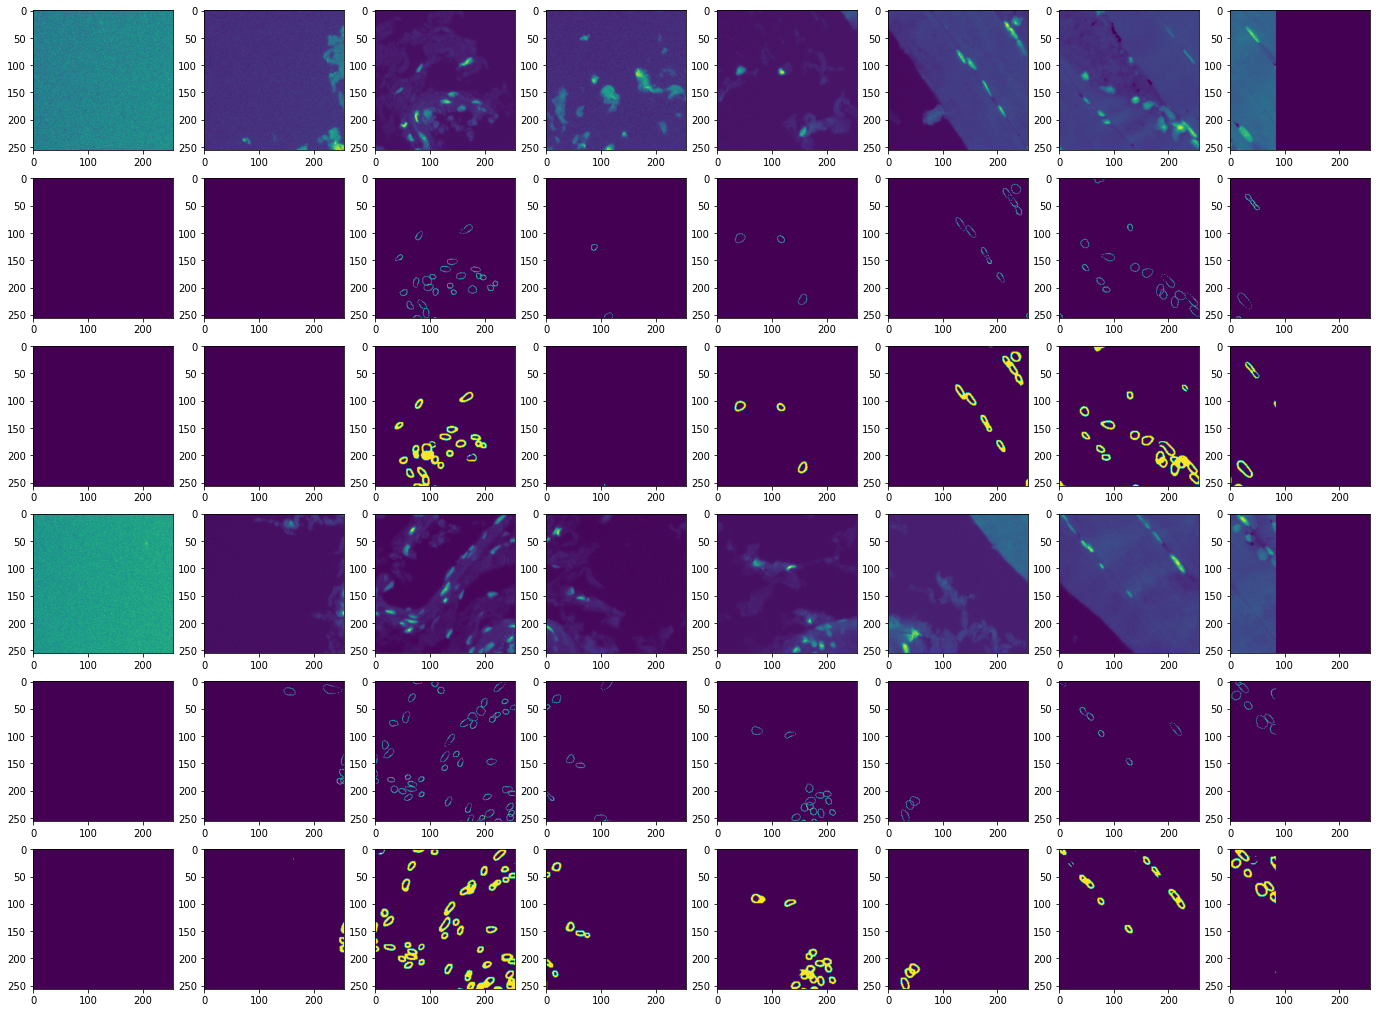

In [ ]:
thres = 0.5

inputs, target, mask_label = next(iter(dataloader['validation']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(output[_].squeeze().numpy())
plt.show()

In [ ]:
model = model_load['model'].to(device)
model.eval()   # Set model to evaluate mode

boundary_correct = 0
boundary_total = 0
background_correct = 0
background_total = 0
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['test']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    boundary_correct += pred[target.bool()].sum().item()
    boundary_total += target.sum().item()
    background_correct += (pred[~mask_label.bool()] == 0.).sum().item()
    background_total += (~mask_label.bool()).sum().item()
    
epoch_bdry_acc = boundary_correct / boundary_total
epoch_bkgd_acc = background_correct / background_total
epoch_acc = (epoch_bdry_acc + epoch_bkgd_acc) / 2
print('Validation Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_bdry_acc, epoch_bkgd_acc, epoch_acc))

Validation Boundary Acc: 0.943833, Background Acc: 0.994962, Overall Acc: 0.969397


In [ ]:
model.eval()   # Set model to evaluate mode

numerator = 0.
denominator = 0.
epsilon = 1e-6
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['test']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    numerator += 2 * torch.sum(pred * target).item() + epsilon
    denominator += (torch.sum(pred).item() + torch.sum(target).item() + epsilon)
    
dice = numerator / denominator
print('Validation Dice score: {:4f}'.format(dice))

Validation Dice score: 0.272767


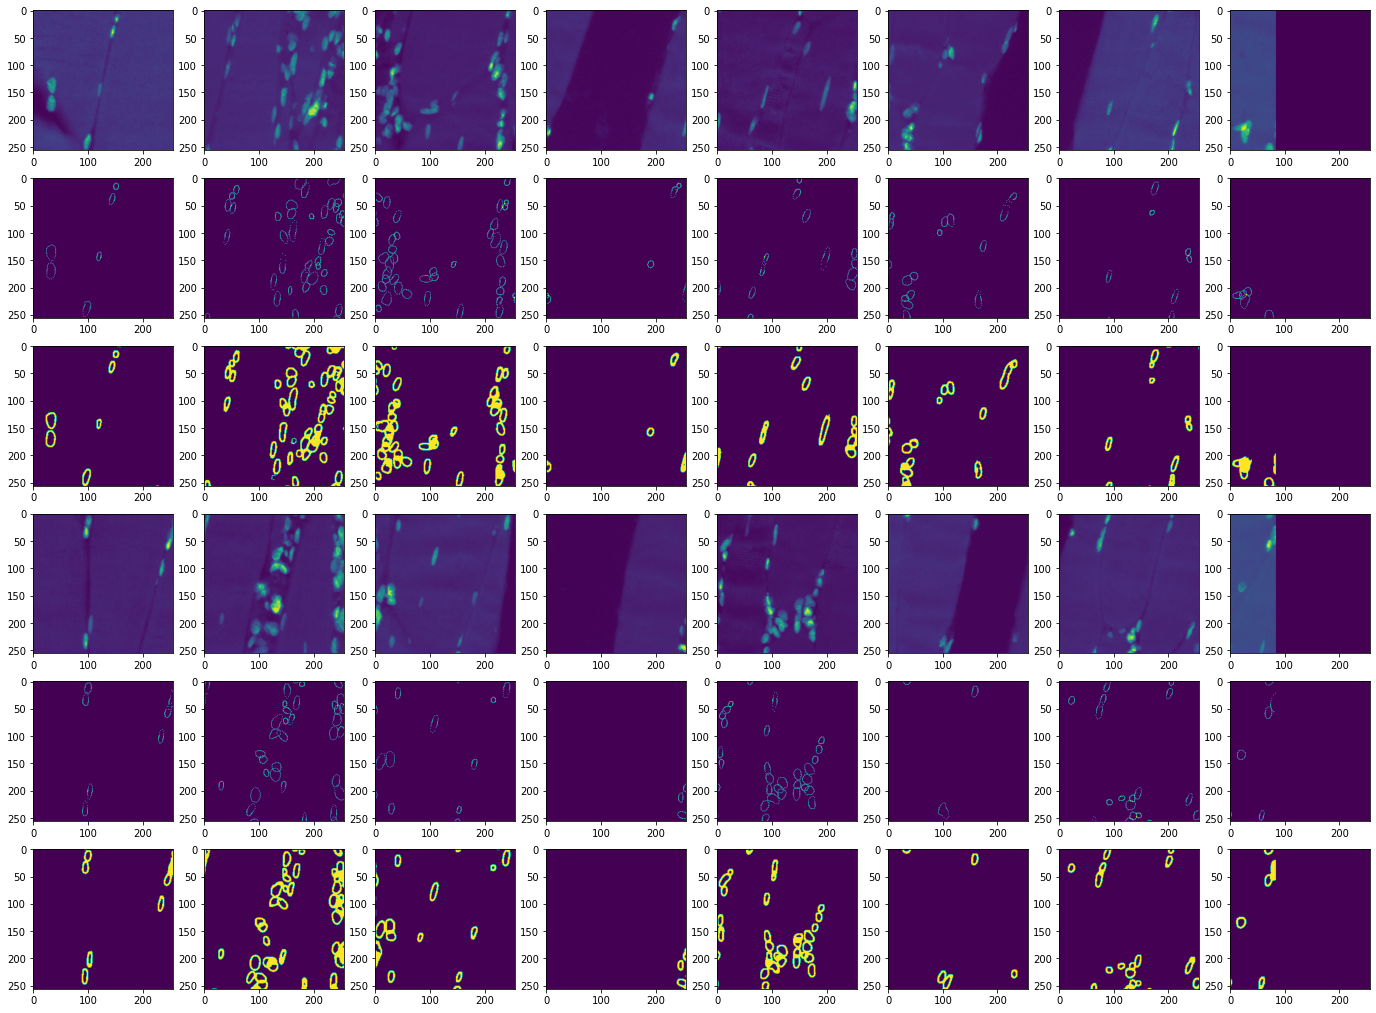

In [ ]:
thres = 0.5

inputs, target, mask_label = next(iter(dataloader['test']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(output[_].squeeze().numpy())
plt.show()

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model_load = torch.load('./Colton AI project/Myositis Images/model_tile/unet_fa_{:.3f}_ba_{:.3f}.pt'.format(0.974, 0.903), map_location=device)
model = model_load['model'].to(device)

Using cache found in /home/fz477/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
model.eval()   # Set model to evaluate mode

boundary_correct = 0
boundary_total = 0
background_correct = 0
background_total = 0
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['validation']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    boundary_correct += pred[target.bool()].sum().item()
    boundary_total += target.sum().item()
    background_correct += (pred[~mask_label.bool()] == 0.).sum().item()
    background_total += (~mask_label.bool()).sum().item()
    
epoch_bdry_acc = boundary_correct / boundary_total
epoch_bkgd_acc = background_correct / background_total
epoch_acc = (epoch_bdry_acc + epoch_bkgd_acc) / 2
print('Validation Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_bdry_acc, epoch_bkgd_acc, epoch_acc))

Validation Boundary Acc: 0.973662, Background Acc: 0.990485, Overall Acc: 0.982073


In [ ]:
model.eval()   # Set model to evaluate mode

numerator = 0.
denominator = 0.
epsilon = 1e-6
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['validation']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    numerator += 2 * torch.sum(pred * target).item() + epsilon
    denominator += (torch.sum(pred).item() + torch.sum(target).item() + epsilon)
    
dice = numerator / denominator
print('Validation Dice score: {:4f}'.format(dice))

Validation Dice score: 0.258333


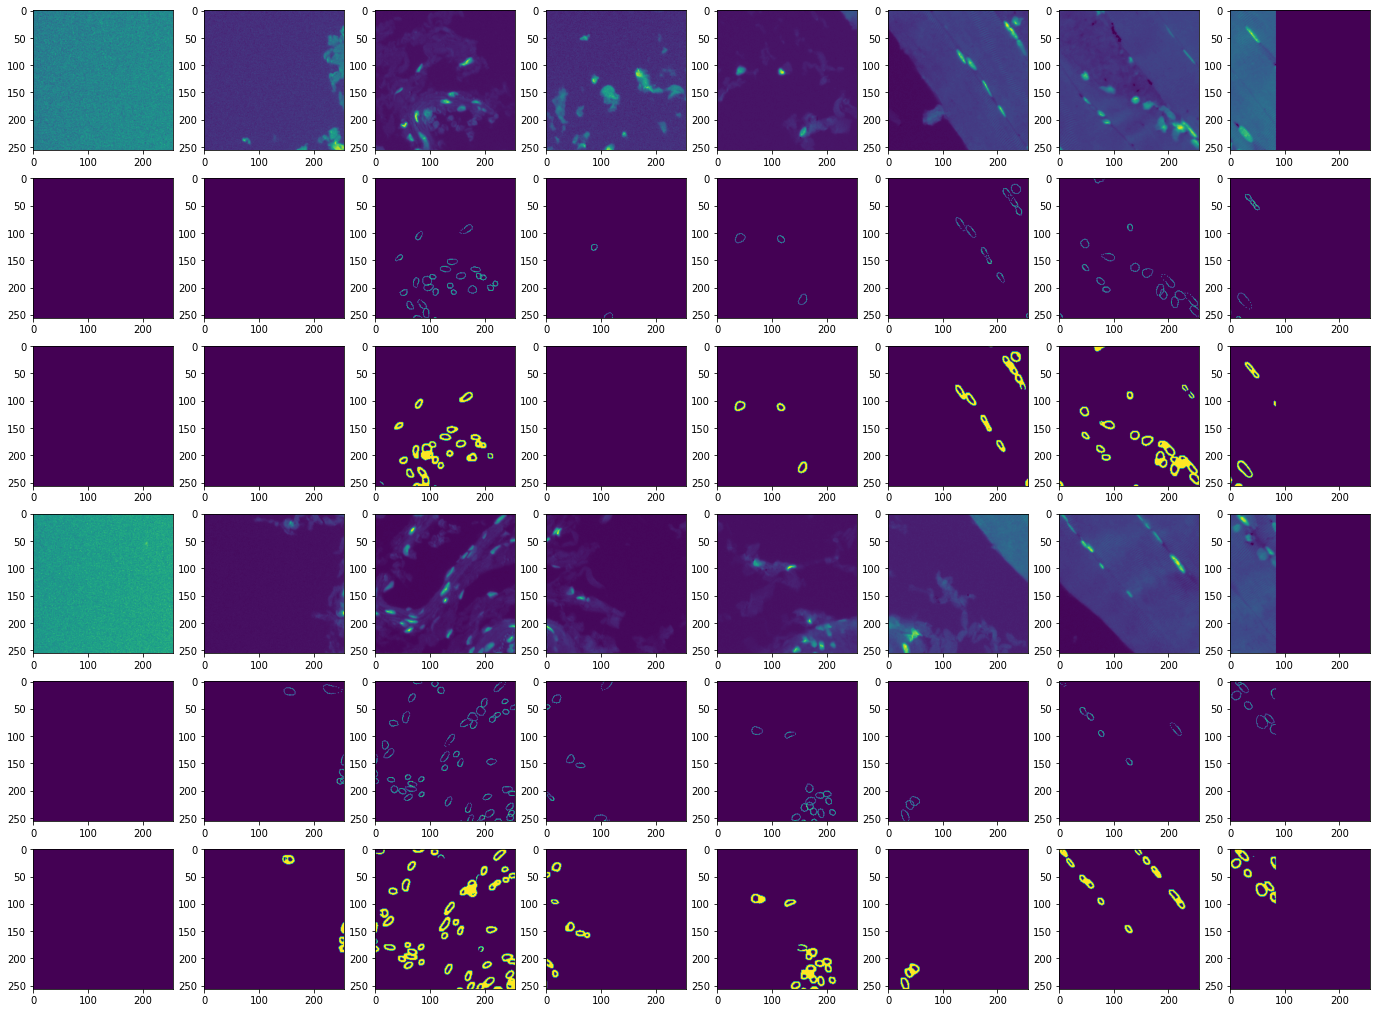

In [ ]:
thres = 0.5

inputs, target, mask_label = next(iter(dataloader['validation']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(output[_].squeeze().numpy())
plt.show()

In [ ]:
model = model_load['model'].to(device)
model.eval()   # Set model to evaluate mode

boundary_correct = 0
boundary_total = 0
background_correct = 0
background_total = 0
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['test']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    boundary_correct += pred[target.bool()].sum().item()
    boundary_total += target.sum().item()
    background_correct += (pred[~mask_label.bool()] == 0.).sum().item()
    background_total += (~mask_label.bool()).sum().item()
    
epoch_bdry_acc = boundary_correct / boundary_total
epoch_bkgd_acc = background_correct / background_total
epoch_acc = (epoch_bdry_acc + epoch_bkgd_acc) / 2
print('Validation Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_bdry_acc, epoch_bkgd_acc, epoch_acc))

Validation Boundary Acc: 0.960629, Background Acc: 0.993109, Overall Acc: 0.976869


In [ ]:
model.eval()   # Set model to evaluate mode

numerator = 0.
denominator = 0.
epsilon = 1e-6
thres = 0.5

# Iterate over data.
for inputs, target, mask_label in dataloader['test']:
    inputs = inputs.to(device)
    target = target.to(device)
    mask_label = mask_label.to(device)

    outputs = model(inputs)
    pred = (outputs > thres).float()

    # statistics
    numerator += 2 * torch.sum(pred * target).item() + epsilon
    denominator += (torch.sum(pred).item() + torch.sum(target).item() + epsilon)
    
dice = numerator / denominator
print('Validation Dice score: {:4f}'.format(dice))

Validation Dice score: 0.260225


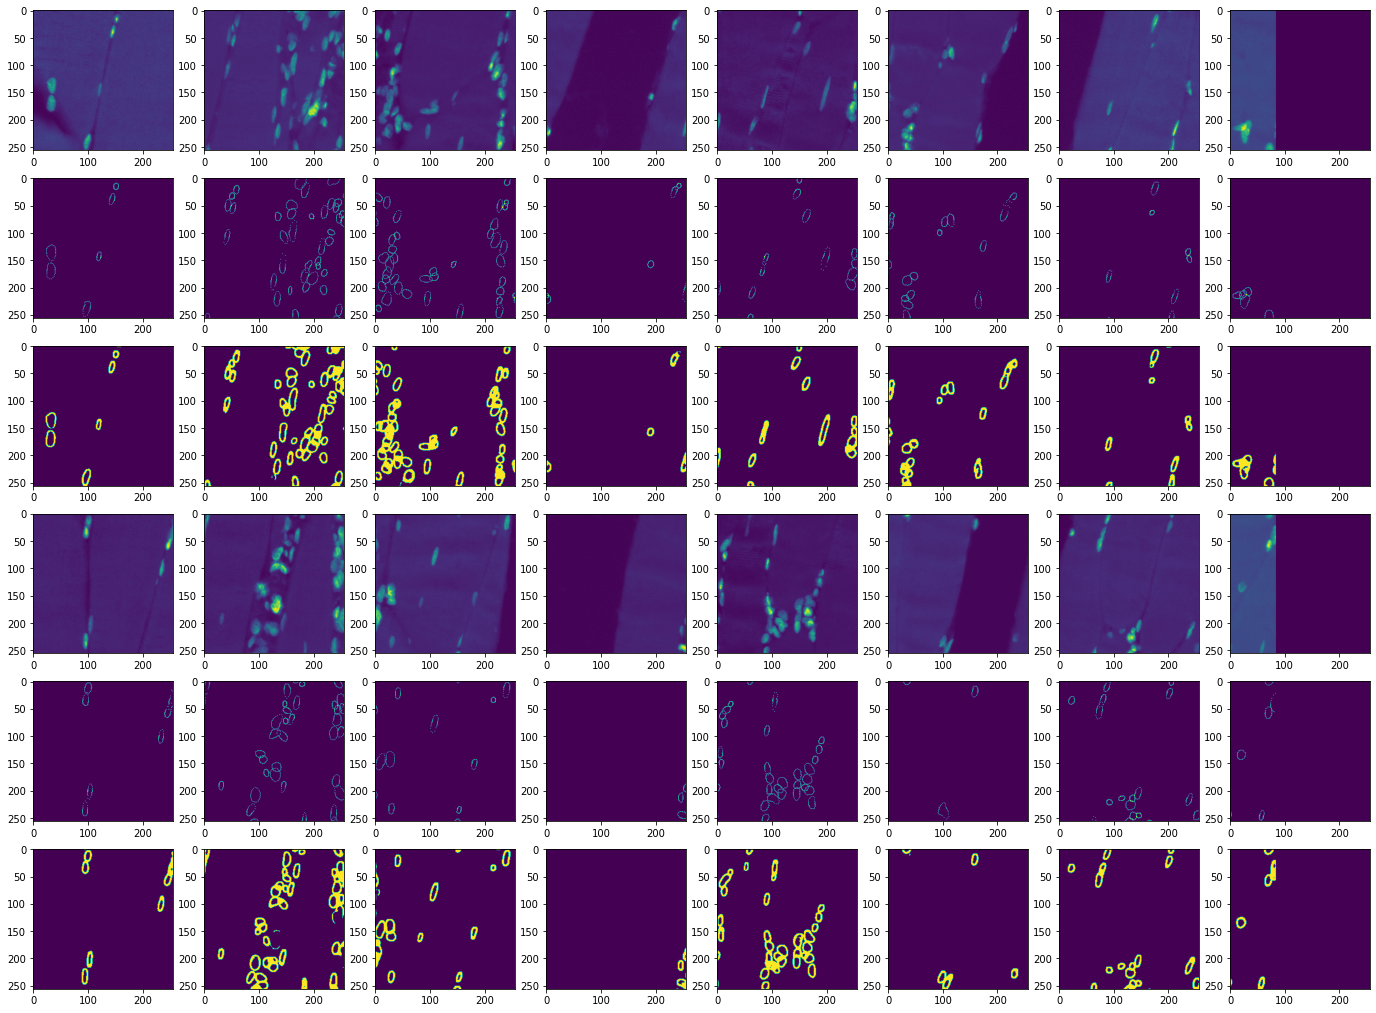

In [ ]:
thres = 0.5

inputs, target, mask_label = next(iter(dataloader['test']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(6,8,_+1)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+9)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+17)
    plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze().numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy())
    plt.subplot(6,8,_+33)
    plt.imshow(output[_].squeeze().numpy())
plt.show()